useful resource: https://towardsdatascience.com/a-complete-exploratory-data-analysis-and-visualization-for-text-data-29fb1b96fb6a

In [18]:
#code needed to use colab notebook
#if you're using juptyer notebook then skip this line
from google.colab import drive
drive.mount('/content/gdrive')

ModuleNotFoundError: No module named 'google.colab'

## these modules need to be installed before starting

In [ ]:
#pip install chart_studio 

In [ ]:
#pip install scattertext

In [19]:
#!python -m spacy download en_core_web_sm

In [20]:
import pandas as pd
import numpy as np
from textblob import TextBlob
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
import warnings 
warnings.filterwarnings('ignore')
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (10.0, 6.0)
import plotly.graph_objs as go
import chart_studio.plotly as py
import cufflinks
pd.options.display.max_columns = 30
from IPython.core.interactiveshell import InteractiveShell
import plotly.figure_factory as ff
InteractiveShell.ast_node_interactivity = 'all'
from plotly.offline import iplot
cufflinks.go_offline()
cufflinks.set_config_file(world_readable=True, theme='pearl')
from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.manifold import TSNE
from bokeh.plotting import figure, output_file, show
from bokeh.models import Label
from bokeh.io import output_notebook
output_notebook()
from collections import Counter
import scattertext as st
import spacy
from pprint import pprint
import en_core_web_sm
#nlp = spacy.load('en_core_web_md')
nlp = en_core_web_sm.load()

Loading BokehJS ...

In [21]:
#%cd "gdrive/My Drive/Colab Notebooks"
!ls

20200504-193926_joe_biden_nlp.csv
20200504-193926_joe_biden_nlp_subs.csv
20200504-193926_joe_biden_nlp_subs_clean.csv
20200504-193926_joe_biden_nlp_subs_clean_expanded.csv
Convention-Visualization.html
Extract_subtitles.ipynb
Language_model.ipynb
models
nlp_EDA.ipynb
nlp_EDA_v2.ipynb
nlp_EDA_v3.ipynb
nlp_EDA_v4.ipynb
nlp_export.pkl
nlp_model_training.ipynb


In [22]:
# load train_cleaned.csv
filename = "20200504-193926_joe_biden_nlp_subs_clean.csv"
df = pd.read_csv(filename, index_col=0)

df.head()

,Bias_num,text
0,0,who hasn't been shocked by a recent electricit...
1,0,you're one of the greatest con men of all time...
2,0,if you thought the insults hold between North ...
3,0,bravery courage defiance heartbreak they're no...
5,0,Jeffrey Epstein was a billionaire businessma...


## Analysis

In [23]:
#calculate number of characters
df['review_len'] = df['text'].astype(str).apply(len)

#calculate number of words
df['word_count'] = df['text'].apply(lambda x: len(str(x).split()))
df.head()

,Bias_num,text,review_len,word_count
0,0,who hasn't been shocked by a recent electricit...,10092,1861
1,0,you're one of the greatest con men of all time...,4741,963
2,0,if you thought the insults hold between North ...,20819,3804
3,0,bravery courage defiance heartbreak they're no...,27328,5125
5,0,Jeffrey Epstein was a billionaire businessma...,32380,5984


(array([316., 198., 109.,  47.,  29.,  16.,  10.,  11.,   3.,   4.]),
 array([   200. ,  13893.3,  27586.6,  41279.9,  54973.2,  68666.5,
         82359.8,  96053.1, 109746.4, 123439.7, 137133. ]),
 <a list of 10 Patch objects>)

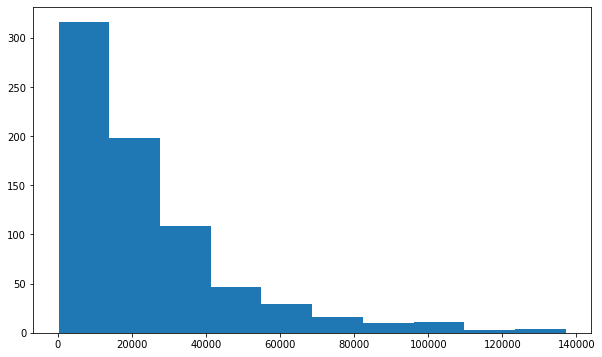

In [24]:
plt.hist(df['review_len'])

(array([350., 183., 107.,  40.,  26.,  12.,  15.,   4.,   2.,   4.]),
 array([1.90000e+01, 2.69310e+03, 5.36720e+03, 8.04130e+03, 1.07154e+04,
        1.33895e+04, 1.60636e+04, 1.87377e+04, 2.14118e+04, 2.40859e+04,
        2.67600e+04]),
 <a list of 10 Patch objects>)

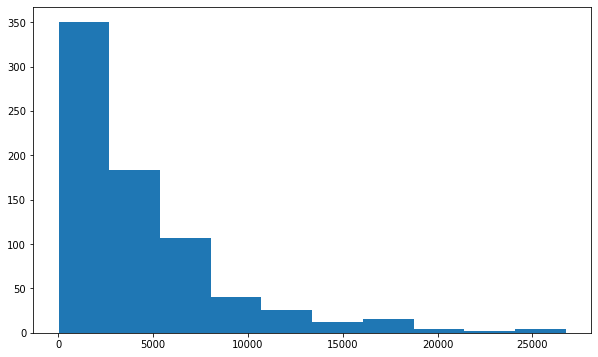

In [27]:
plt.hist(df['word_count'])

In [28]:
x1 = df.loc[df['Bias_num'] == 1, 'word_count']
x0 = df.loc[df['Bias_num'] == 0, 'word_count']

trace1 = go.Histogram(
    x=x0, name='Right',
    opacity=0.75
)
trace2 = go.Histogram(
    x=x1, name = 'Left',
    opacity=0.75
)

data = [trace1, trace2]
layout = go.Layout(barmode='overlay', title='Distribution of word count based on bias')
fig = go.Figure(data=data, layout=layout)
fig.show()

In [30]:
x1 = df.loc[df['Bias_num'] == 1, 'review_len']
x0 = df.loc[df['Bias_num'] == 0, 'review_len']

trace1 = go.Histogram(
    x=x0, name='Right',
    opacity=0.75
)
trace2 = go.Histogram(
    x=x1, name = 'Left',
    opacity=0.75
)

data = [trace1, trace2]
layout = go.Layout(barmode='overlay', title='Distribution of review_len based on bias')
fig = go.Figure(data=data, layout=layout)
fig.show()

## The distribution of top unigrams before removing stop words

In [31]:
def get_top_n_words(corpus, n=None):
    vec = CountVectorizer().fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]
common_words = get_top_n_words(df['text'], 20)
df1 = pd.DataFrame(common_words, columns = ['text' , 'count'])
df1
df1.groupby('text').sum()['count'].sort_values(ascending=False).iplot(
    kind='bar', yTitle='Count', linecolor='black', title='Top 20 words in review before removing stop words')

,text,count
0,the,150377
1,to,93324
2,that,79909
3,of,73625
4,you,73516
5,it,55656
6,in,54623
7,is,43256
8,we,38911
9,was,28350


## The distribution of top unigrams after removing stop words

In [32]:
def get_top_n_words(corpus, n=None):
    vec = CountVectorizer(stop_words = 'english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]
common_words = get_top_n_words(df['text'], 20)
df2 = pd.DataFrame(common_words, columns = ['text' , 'count'])
df2
df2.groupby('text').sum()['count'].sort_values(ascending=False).iplot(
    kind='bar', yTitle='Count', linecolor='black', title='Top 20 words in review after removing stop words')

,text,count
0,know,19563
1,people,15001
2,like,14407
3,just,13242
4,think,11523
5,don,9828
6,right,9366
7,going,7726
8,ve,7698
9,said,7333


## The distribution of top bigrams before removing stop words

In [33]:
def get_top_n_bigram(corpus, n=None):
    vec = CountVectorizer(ngram_range=(2, 2)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]
common_words = get_top_n_bigram(df['text'], 20)
df3 = pd.DataFrame(common_words, columns = ['text' , 'count'])
df3
df3.groupby('text').sum()['count'].sort_values(ascending=False).iplot(
    kind='bar', yTitle='Count', linecolor='black', title='Top 20 bigrams in review before removing stop words')


,text,count
0,of the,14010
1,in the,13371
2,you know,11959
3,to be,6691
4,you re,6661
5,to the,6420
6,we re,6065
7,on the,5684
8,going to,5055
9,it was,4911


## The distribution of top bigrams after removing stop words

In [34]:
def get_top_n_bigram(corpus, n=None):
    vec = CountVectorizer(ngram_range=(2, 2), stop_words='english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]
common_words = get_top_n_bigram(df['text'], 20)
df4 = pd.DataFrame(common_words, columns = ['text' , 'count'])
df4
df4.groupby('text').sum()['count'].sort_values(ascending=False).iplot(
    kind='bar', yTitle='Count', linecolor='black', title='Top 20 bigrams in review after removing stop words')

,text,count
0,don know,1959
1,united states,1459
2,ve got,1395
3,don think,986
4,donald trump,977
5,don want,835
6,little bit,814
7,make sure,625
8,years ago,618
9,lot people,574


## The distribution of Top trigrams before removing stop words

In [35]:
def get_top_n_trigram(corpus, n=None):
    vec = CountVectorizer(ngram_range=(3, 3)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]
common_words = get_top_n_trigram(df['text'], 20)
df5 = pd.DataFrame(common_words, columns = ['text' , 'count'])
df5
df5.groupby('text').sum()['count'].sort_values(ascending=False).iplot(
    kind='bar', yTitle='Count', linecolor='black', title='Top 20 trigrams in review before removing stop words')

,text,count
0,one of the,1827
1,the united states,1286
2,going to be,1120
3,re going to,1054
4,you have to,859
5,be able to,709
6,if you re,696
7,we have to,696
8,in terms of,687
9,you want to,682


## The distribution of Top trigrams after removing stop words

In [36]:
def get_top_n_trigram(corpus, n=None):
    vec = CountVectorizer(ngram_range=(3, 3), stop_words='english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]
common_words = get_top_n_trigram(df['text'], 20)
df6 = pd.DataFrame(common_words, columns = ['text' , 'count'])
df6
df6.groupby('text').sum()['count'].sort_values(ascending=False).iplot(
    kind='bar', yTitle='Count', linecolor='black', title='Top 20 trigrams in review after removing stop words')

,text,count
0,know don know,146
1,billions billions billions,128
2,president united states,114
3,don know don,88
4,don know know,87
5,want make sure,81
6,chinese communist party,78
7,corona virus pemic,70
8,world health organization,69
9,know ve got,67


## Finding characteristic terms and their associations

In [37]:
#convert Bias_num to string
df_corpus = df.copy()
df_corpus['Bias_num'] = df_corpus['Bias_num'].apply(str)
df_corpus.dtypes

Bias_num      object
text          object
review_len     int64
word_count     int64
dtype: object

In [38]:
df_corpus.head()

,Bias_num,text,review_len,word_count
0,0,who hasn't been shocked by a recent electricit...,10092,1861
1,0,you're one of the greatest con men of all time...,4741,963
2,0,if you thought the insults hold between North ...,20819,3804
3,0,bravery courage defiance heartbreak they're no...,27328,5125
5,0,Jeffrey Epstein was a billionaire businessma...,32380,5984


In [39]:
#Following are the terms that differentiate the review text from a general English corpus.
corpus = st.CorpusFromPandas(df_corpus, category_col='Bias_num', text_col='text', nlp=nlp).build()
print(list(corpus.get_scaled_f_scores_vs_background().index[:10]))

['gon', 'trump', 'underst', 'thous', 'biden', 'yeah', 'okay', 'pemic', 'applause', 'coronavirus']


In [40]:
#Following are the terms in review text that are most associated with right wing channels:
term_freq_df = corpus.get_term_freq_df()
term_freq_df['Right score'] = corpus.get_scaled_f_scores("1")
pprint(list(term_freq_df.sort_values(by='Right score', ascending=False).index[:20]))

['fucking',
 'fbi',
 'guys',
 'you got',
 'black',
 "here 's",
 'guy',
 "'re gon",
 'quote',
 'i go',
 'i said',
 'this guy',
 'mean i',
 'all right',
 'the left',
 'these guys',
 "'m gon",
 'yeah',
 'i got',
 'hmm']


In [41]:
#Following are the terms in review text that are most associated with left wing channels:
term_freq_df = corpus.get_term_freq_df()
term_freq_df['Left score'] = corpus.get_scaled_f_scores("0")
pprint(list(term_freq_df.sort_values(by='Left score', ascending=False).index[:20]))

['applause',
 '♪',
 'narrator',
 'amazon',
 "we\\'re",
 'laughter',
 'er',
 "we\\'ve",
 're',
 "i\\'m",
 'that\\',
 "that\\ 's",
 "don\\'t",
 'it\\',
 "it\\ 's",
 '♪ ♪',
 'he\\',
 'canada',
 'and the',
 "he\\ 's"]
